## Frequency Shift Chirp Modulation: La modulación LoRa

LoRa emplea **Chirps** como base de cada símbolo modulado. Un **chirp** es una señal senoidal que aumenta o decrementa su frecuencia de forma lineal.


Cada símbolo $s(nT_s)$ es un numero real que se genera a partir de un vector binario $w(nT_s)$ de longitud igual al **Spreading Factor** (SF), el cual puede tomar valores entre 7 y 12.


- **Vector de bits**: $w(nT_s) = [w_0(nT_s), \dots, w_{\mathrm{SF}-1}(nT_s)]$, donde cada $w_h(nT_s) \in \{0, 1\}$.  

- **Combinaciones posibles**: este vector de $\mathrm{SF}$ bits admite $2^{\mathrm{SF}}$ símbolos distintos.



Para convertir el vector binario $w(nT_s)$ a un valor real $s(nT_s)$, usamos la siguiente  ecuación propuesta en el paper de Vangelista:

$$
s(nT_s) \;=\; \sum_{h=0}^{\mathrm{SF}-1} w_h(nT_s)\,\cdot\,2^{h}
$$

donde:

* $w_h(nT_s)$ es el bit en la posición $h$ del vector de bits $w(nT_s)$.

* Cada bit se multiplica por $2^h$ (su “peso”) y se suman todos los términos.


Podemos ver entonces que el símbolo $s(nT_s)$ puede tomar cualquiera de los valores enteros:

$$
s(nT_s) \;\in\; \{\,0, 1, 2, \dots, 2^{\mathrm{SF}} -1\}
$$




In [79]:
import numpy as np

def generate_random_uniform_bits(sf, num_paquetes, ref):
    # Creamos una matriz de números aleatorios de tamaño (num_paquetes x sf)
    z = np.random.uniform(size=(num_paquetes, sf))
    
    # Generamos los bits con una probabilidad a priori dada por ref
    bits = (z > ref).astype(np.uint8)

    return bits

def encoder(bits, sf):
    # Generamos polinomio de conversion con los pesos de cada bit
    weights = 2 ** np.arange(sf)[::-1]

    # Producto punto entre bits y pesos
    symbols = bits.dot(weights)     

    return symbols

def decoder(symbols, sf):    
    # Preparamos la matriz de salida
    n_blocks = symbols.size
    bits = np.zeros((n_blocks, sf), dtype=np.uint8)

    # Por cada símbolo
    for y in range(n_blocks):
        val = symbols[y]
        # Extraemos bit a bit, de LSB a MSB
        for i in range(sf):
            bits[y, sf - 1 - i] = val % 2
            val //= 2

    return bits

def BER(enviados, recibidos):
    # Contamos diferencias y calculamos probabilidad de error
    errores = np.sum(enviados != recibidos)

    # Total de bits
    total_bits = enviados.size
    
    # Tasa de error
    pe = errores / total_bits

    print(f"\nLa Probabilidad de error en la decodificación es: {pe:.6f}")
    

# Ejemplo de uso:
SF = 8                     # puede ser cualquiera entre 7 y 12
numero_paquetes = 2
bits_send = generate_random_uniform_bits(SF, numero_paquetes, 0.5)

print(bits_send[0:2])           # los primeros 9 bits

symbols = encoder(bits_send, SF)

bits_recv = decoder(symbols, SF)

print(bits_recv[0:2])           # los primeros 9 bits

BER(bits_send, bits_recv)


[[1 1 0 0 0 1 0 0]
 [1 1 1 0 1 1 0 0]]
[[1 1 0 0 0 1 0 0]
 [1 1 1 0 1 1 0 0]]

La Probabilidad de error en la decodificación es: 0.000000


**Waveform Former**

En la modulación LoRa, cada símbolo tiene una duración de **Ts** y se muestrea a intervalos de tiempo **T**. El n-ésimo símbolo se representa como **s(nTs)**. La señal modulada resultante se expresa con la siguiente fórmula:

$$
c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j 2\pi \left( \left[s(nT_s) + k\right] \bmod 2^{SF} \right) \cdot \frac{kTB}{2^{SF}}}
$$


El tiempo de muestreo $T$ está relacionado con el ancho de banda $B$ mediante:

$$
T = \frac{1}{B} 
$$

El tiempo de simbolo es: 

$$
T_s = 2^{SF}*{T} 
$$


$$
c(nTs + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j 2 \pi \left[ {(s(nTs) + k) \mod 2^{SF}} \right]} \frac{k}{{2^{SF}}}
$$


para $k = 0, 1, 2, ..., 2^{SF} - 1$, donde:

* **SF** es el *Spreading Factor* (factor de expansión).
* **n** indice asociado al Tiempo de símbolo.
* **s(nTs)** determina la frecuencia inicial del chirp.
* **k** representa el índice de tiempo dentro del símbolo.
* El operador $\mod\ 2^{SF}$ asegura que la frecuencia vuelva al inicio una vez alcanzado el límite superior del ancho de banda.


Esta expresión describe una **señal tipo chirp**, ya que la frecuencia aumenta linealmente con respecto al tiempo (representado por **k**). Cada forma de onda difiere de una forma base (que comienza con frecuencia cero) por un desplazamiento de frecuencia dado por **s(nTs)**.

Por esta razón, esta modulación se conoce como **FCSM** (*Frequency-Coded Chirp Spread Modulation*).



La expresión $[(s(nT_s) + k) \mod 2^{SF}]$ determina la fase de inicio dentro del chirp, y la fracción $\frac{k}{2^{SF}}$ controla cuán rápido (o lento) gira esa fase a lo largo del símbolo.

En un chirp lineal, la frecuencia instantánea varía linealmente con el tiempo, y el parámetro $k$ determina la tasa de este cambio. Reducir $k$ a $0.1k$ disminuye la pendiente de la fase, resultando en una menor variación de frecuencia a lo largo del tiempo.

En términos discretos, esto se traduce en una representación de la señal con una pendiente más suave en el vector de muestras, sin alterar la cantidad total de muestras por símbolo, que sigue siendo $2^{SF}$.


In [28]:
def waveform_former(numero_paquetes, sf, symbols):
    M = 2**sf
    # Factor de normalización 1/√M
    norm = 1 / np.sqrt(M)

    # Reservamos la matriz de salida
    waveform = np.zeros((numero_paquetes, M), dtype=complex)

    for n in range (numero_paquetes):
        s_n = symbols[n]
        
        for k in range (M):
            phase_index = (s_n + k) % (2**sf)
            waveform[n, k] = norm * np.exp(1j * 2 * np.pi * phase_index * (k*0.1 /(2**sf)))
        
    return waveform



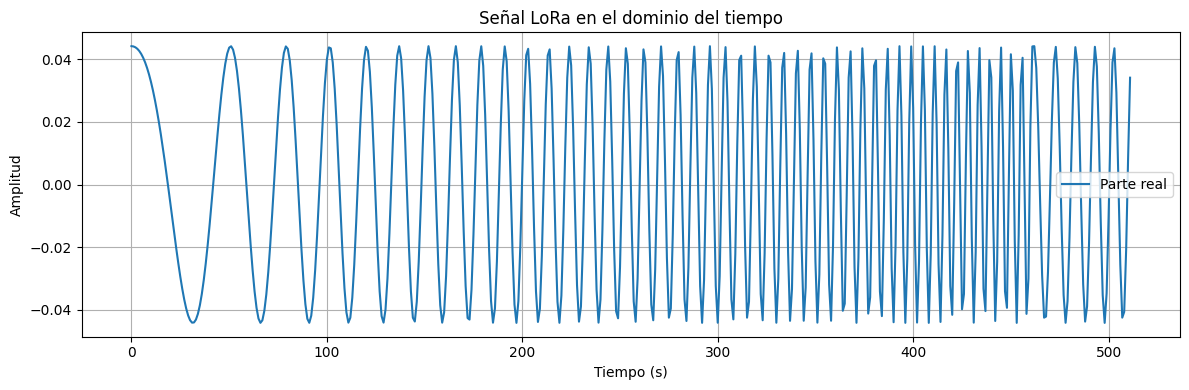

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_frequency_domain(waveform):
    signal = waveform.flatten()

    # Parámetros
    num_samples = signal.size

    # Vector de tiempo
    t = np.arange(num_samples)

    plt.figure(figsize=(12, 4))
    plt.plot(t, signal.real, label='Parte real')
    plt.title('Señal LoRa en el dominio del tiempo')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
num = [50] 
plot_frequency_domain(waveform_former(1, 9, num))